<a href="https://colab.research.google.com/github/sr1jan/BareHands_Detection/blob/master/BareHands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Using third-party implementations of Mask R-CNN by [matterport](https://github.com/matterport/Mask_RCNN)



In [0]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.83 MiB | 12.59 MiB/s, done.
Resolving deltas: 100% (569/569), done.


In [0]:
%cd Mask_RCNN/

/content/Mask_RCNN


In [0]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcn

In [0]:
!pip install -r requirements.txt

     |████████████████████████████████| 163kB 6.4MB/s 
     |████████████████████████████████| 204kB 41.9MB/s 


In [0]:
!pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg
Requires: 
Required-by: 


# Dataset Preparation


In [0]:
drive_path='/content/gdrive/My Drive/BareHands/[sr1]BareHands'

In [0]:
# Librarires required
from os import listdir
import zipfile
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.utils import Dataset, extract_bboxes, compute_ap
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

Using TensorFlow backend.


In [0]:
# unzipping the hand dataset
with zipfile.ZipFile(f'{drive_path}/barehand_imgs_labels_690.zip', 'r') as zip_ref:
  zip_ref.extractall('.')

In [0]:
class HandDataset(Dataset):

	def load_dataset(self, dataset_dir, is_train=True):
		self.add_class("dataset", 1, "hand")
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		num_of_imgs = len(listdir(images_dir))
    # num_for_train = int((num_of_imgs/100) * 80)
    # num_for_test = int((num_of_imgs/100) * 20)
  
		for filename in listdir(images_dir):
			image_id = filename[:-4]
			if is_train and int(image_id) >= int((num_of_imgs/100)*80):
				continue
			if not is_train and int(image_id) < int((num_of_imgs/100)*80):
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	def extract_boxes(self, filename):
		tree = ElementTree.parse(filename)
		root = tree.getroot()
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	def load_mask(self, image_id):
		info = self.image_info[image_id]
		path = info['annotation']
		boxes, w, h = self.extract_boxes(path)
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('hand'))
		return masks, asarray(class_ids, dtype='int32')

	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

In [0]:
# train set
train_set = HandDataset()
train_set.load_dataset('hand', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = HandDataset()
test_set.load_dataset('hand', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 551
Test: 139


# Data Visualization

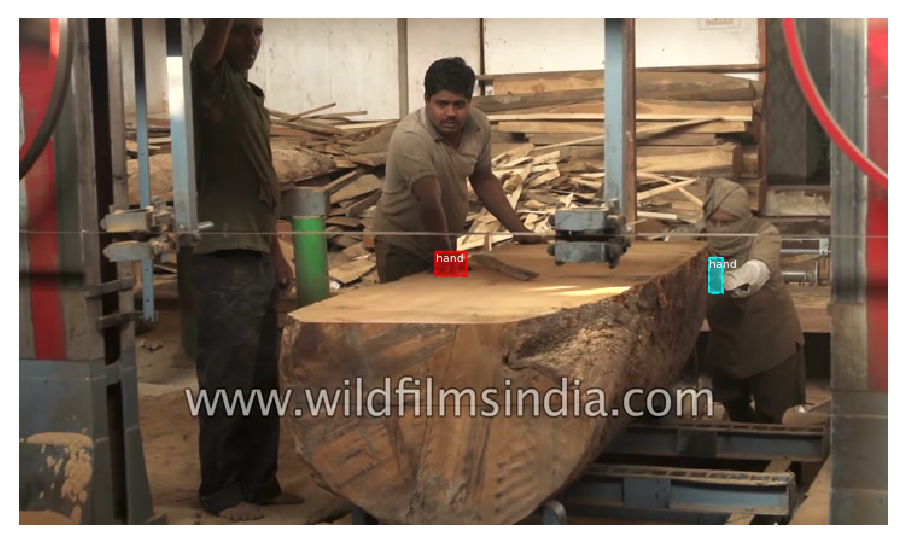

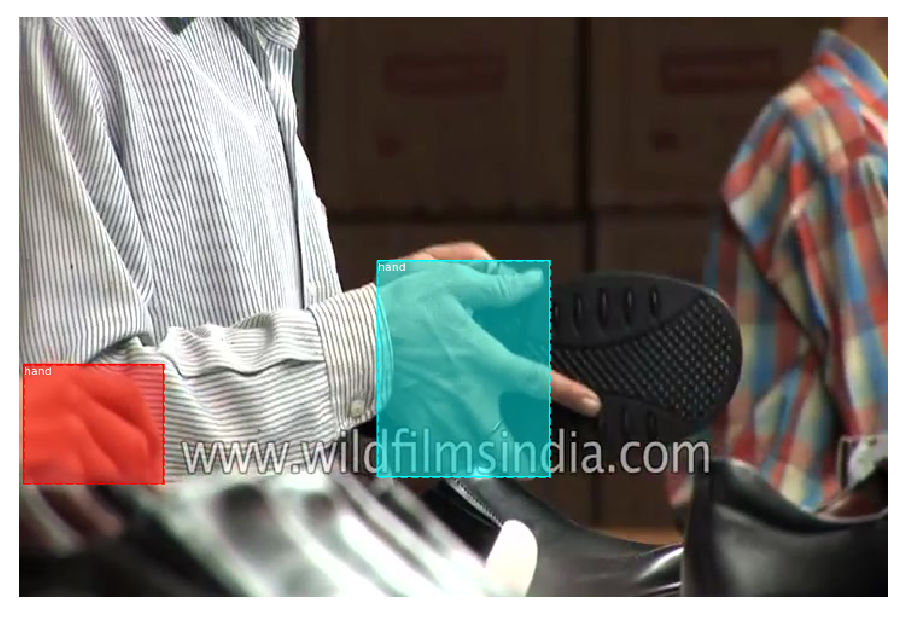

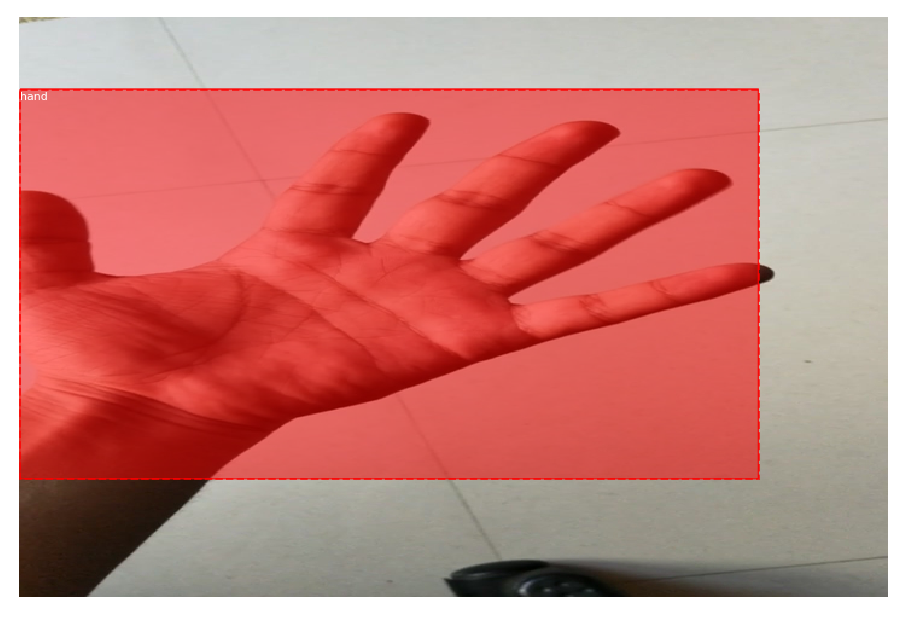

In [0]:
for i in range(42,45):
  image_id = i
  image = train_set.load_image(image_id)
  mask, class_ids = train_set.load_mask(image_id)
  bbox = extract_bboxes(mask)
  display_instances(image, bbox, mask, class_ids, train_set.class_names)

# Model Training

In [0]:
# Model configuration (extends mrcnn.config.Config)
class HandConfig(Config):
	NAME = "hand1_cfg"
	NUM_CLASSES = 1 + 1
	STEPS_PER_EPOCH = 551

	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

config = HandConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
# model definition
model = MaskRCNN(mode='training', model_dir=f'{drive_path}/MRCNN/Model', config=config)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [0]:
# excluding the output layers of pretrained model
model.load_weights(f'{drive_path}/MRCNN/Model/hand1_cfg20191217T1607/mask_rcnn_hand1_cfg_0020.h5', by_name=True)

Re-starting from epoch 20


In [0]:
%reload_ext tensorboard

In [0]:
%tensorboard --logdir='/content/gdrive/My Drive/BareHands/[sr1]BareHands/MRCNN/Model'

Reusing TensorBoard on port 6006 (pid 775), started 1:42:47 ago. (Use '!kill 775' to kill it.)

In [0]:
# fine-tuning the model
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=30, layers='all')


Starting at epoch 20. LR=0.001

Checkpoint Path: /content/gdrive/My Drive/BareHands/[sr1]BareHands/MRCNN/Model/hand1_cfg20191217T1607/mask_rcnn_hand1_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 21/30
551/551 [==============================] - 353s 640ms/step - loss: 0.2167 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0482 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.1300 - val_loss: 1.4475 - val_rpn_class_loss: 0.0642 - val_rpn_bbox_loss: 0.3666 - val_mrcnn_class_loss: 0.0770 - val_mrcnn_bbox_loss: 0.2682 - val_mrcnn_mask_loss: 0.6716
Epoch 22/30
551/551 [==============================] - 295s 535ms/step - loss: 0.1789 - rpn_class_loss: 8.4429e-04 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 0.0064 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.1115 - val_loss: 1.1577 - val_rpn_class_loss: 0.0333 - val_rpn_bbox_loss: 0.3177 - val_mrcnn_class_loss: 0.0491 - val_mrcnn_bbox_loss: 0.2173 - val_mrcnn_mask_loss: 0.5403
Epoch 23/30
551/551 [==============================] - 294s 533ms/step - loss: 0.1951 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0442 - mrcnn_class_loss: 0.0074 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.1153 - val_loss: 1.6321 -

# Evaluation

In [0]:
# Evaluation Config
class PredictionConfig(Config):
	NAME = "hand1_cfg"
	NUM_CLASSES = 1 + 1
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

cfg = PredictionConfig()

In [0]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		sample = expand_dims(scaled_image, 0)
		# prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		APs.append(AP)

	mAP = mean(APs)
	return mAP

In [0]:
# Model to evaluate
model = MaskRCNN(mode='inference', model_dir=f'{drive_path}/MRCNN/Model', config=cfg)
model.load_weights(f'{drive_path}/MRCNN/Model/hand1_cfg20191217T1607/mask_rcnn_hand1_cfg_0028.h5', by_name=True)

Re-starting from epoch 28


In [0]:
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)

test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Train mAP: 0.543
Test mAP: 0.409


In [0]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

# Ground truth vs Prediction
def truth_vs_pred(dataset, model, cfg, n_images=100):
	for i in range(n_images):
		image = dataset.load_image(i)
		mask, _ = dataset.load_mask(i)
		scaled_image = mold_image(image, cfg)
		sample = expand_dims(scaled_image, 0)
		yhat = model.detect(sample, verbose=0)[0]
		plt.figure(figsize=(30,30))
		plt.subplot(n_images, 2, i*2+1)
		# plt.imshow(image)
		plt.title('Actual')
  
		# plot masks
		# for j in range(mask.shape[2]):
			# plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
		plt.subplot(n_images, 2, i*2+2)
		# plt.imshow(image)
		plt.title('Predicted')
		ax = plt.gca()
		# plot each box
		for box in yhat['rois']:
			y1, x1, y2, x2 = box
			width, height = x2 - x1, y2 - y1
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			ax.add_patch(rect)
			im = Image.fromarray(image)
			draw = ImageDraw.Draw(im)
			shape = [(x1,y1), (x2,y2)]
			draw.rectangle(shape, outline='red')
			im.save(f'{drive_path}/MRCNN/Predictions/prediction_model2_epoch28th/test_dataset/{i+1:03}_test.jpg')
			# plt.savefig(f"{drive_path}/Inference/{i+1:03}.jpg",bbox_inches='tight',pad_inches=0)

		# plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


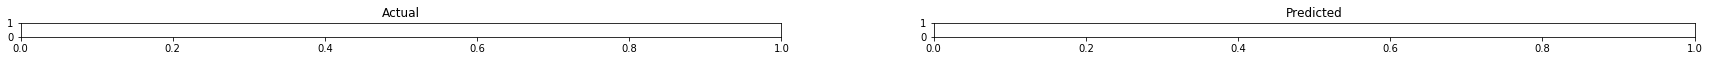

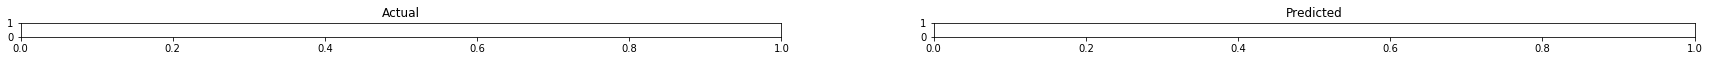

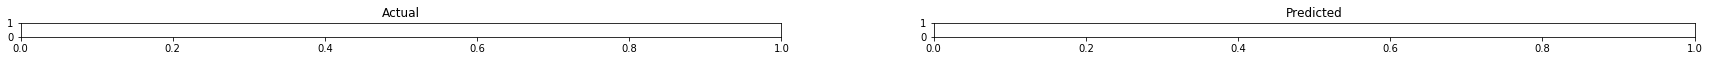

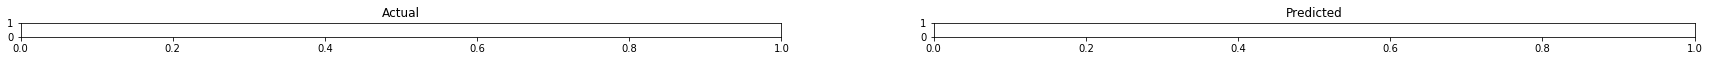

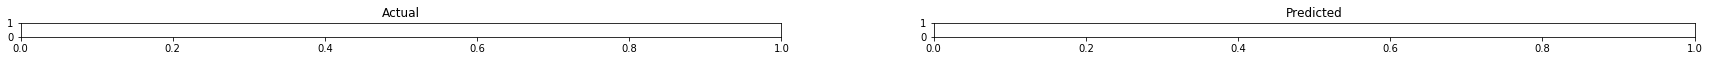

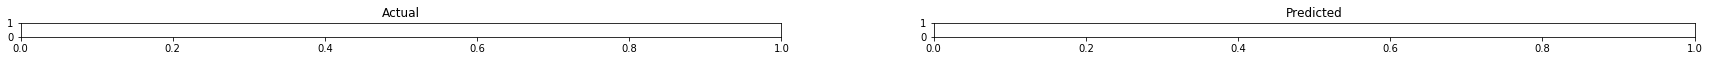

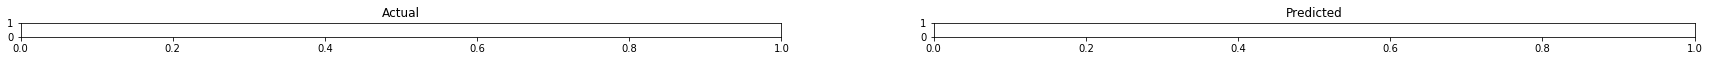

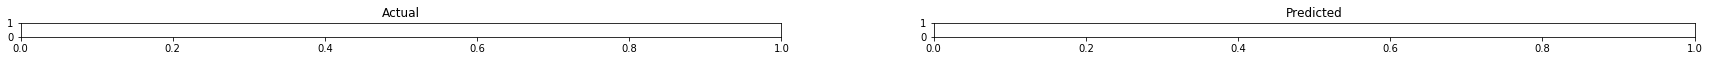

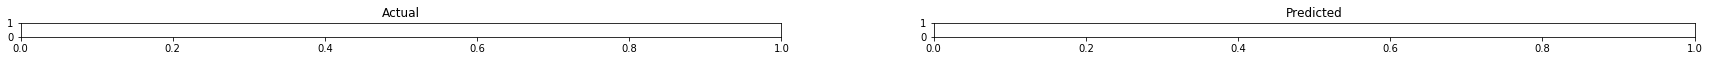

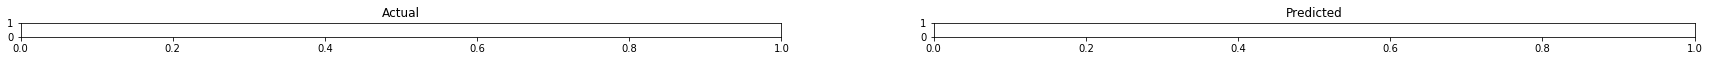

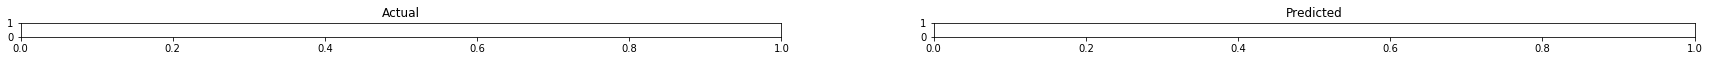

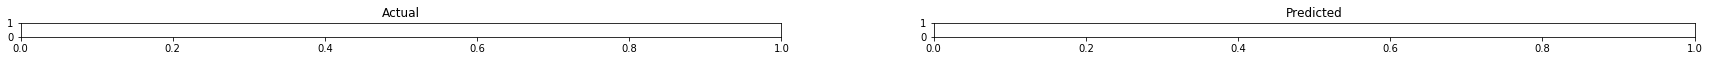

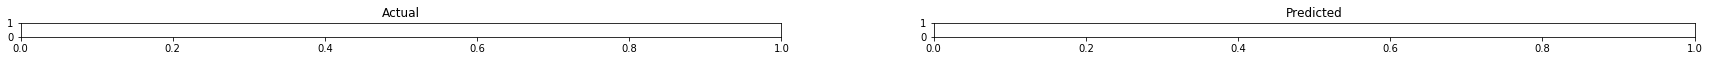

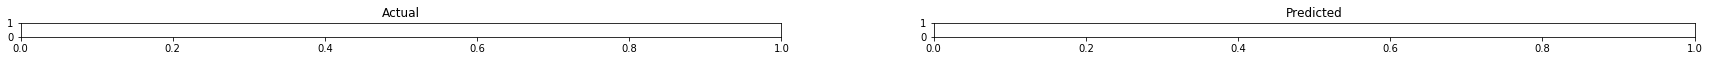

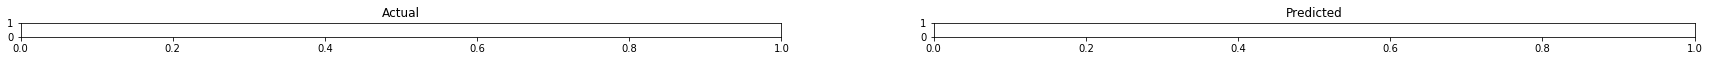

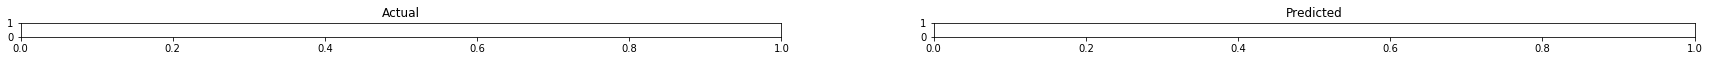

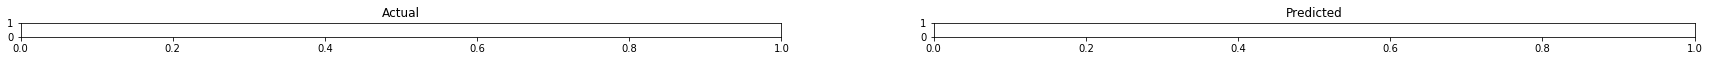

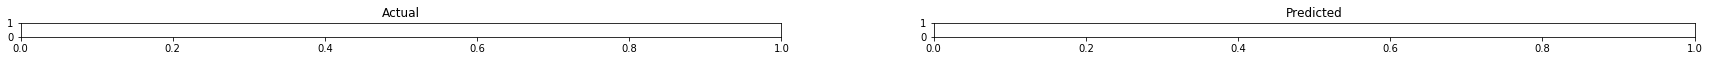

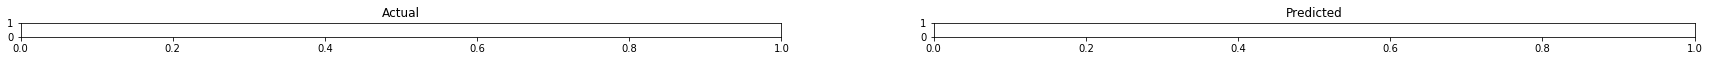

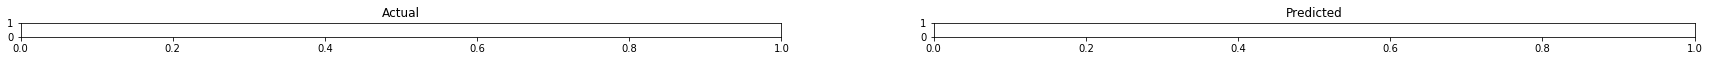

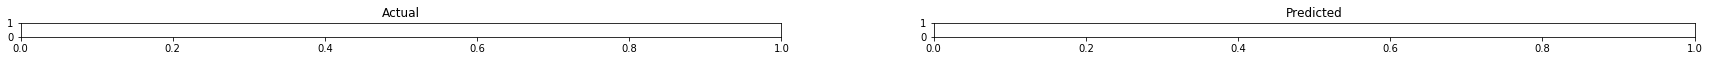

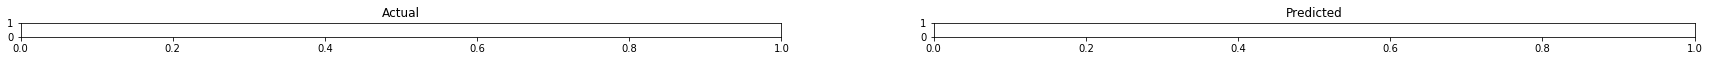

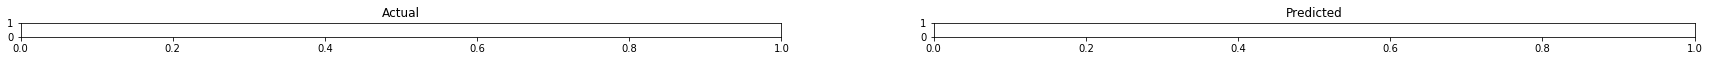

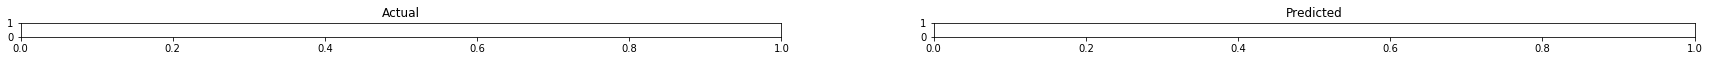

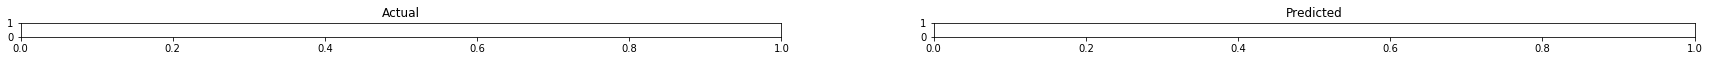

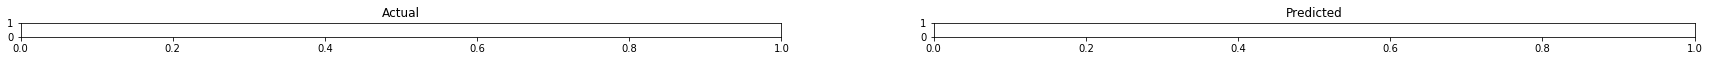

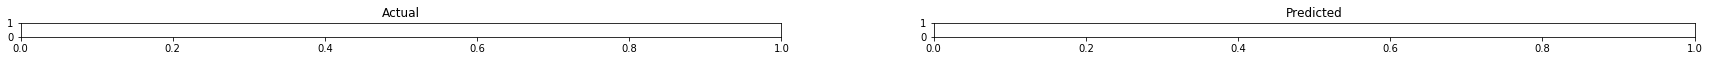

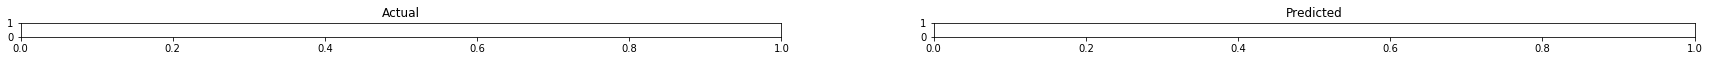

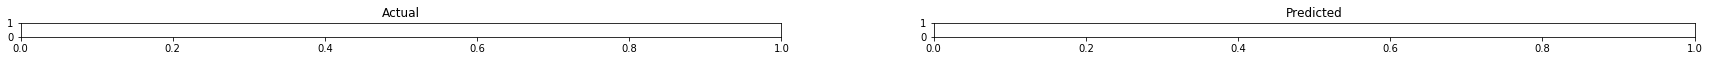

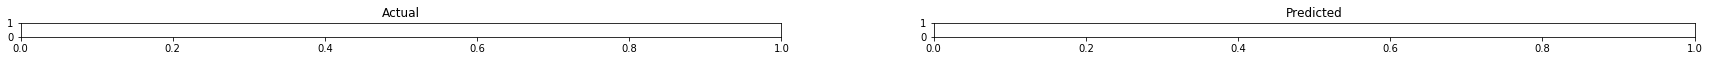

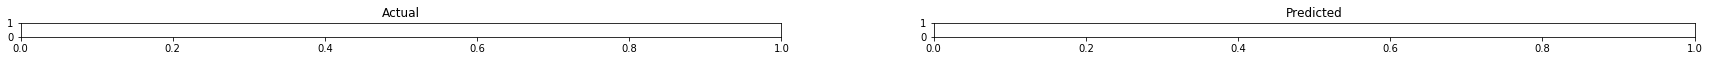

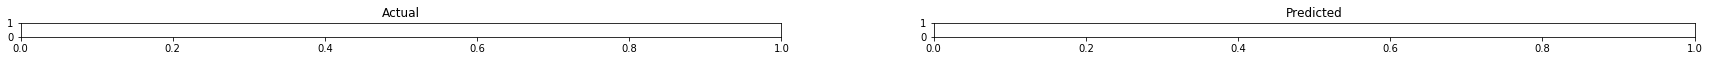

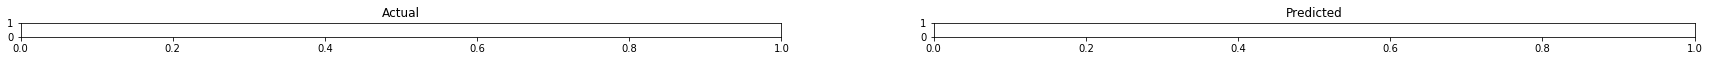

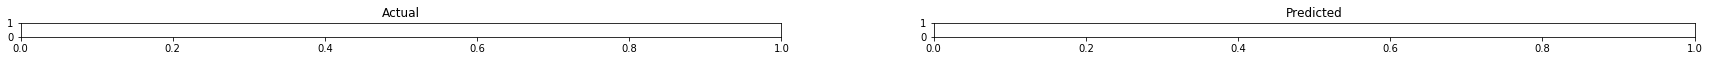

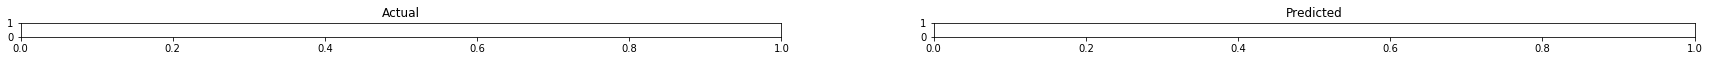

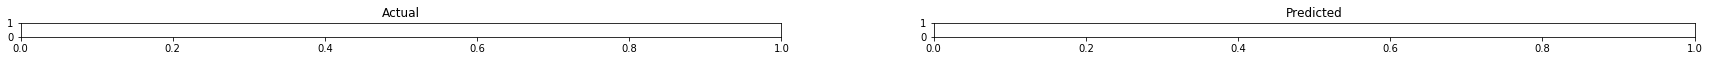

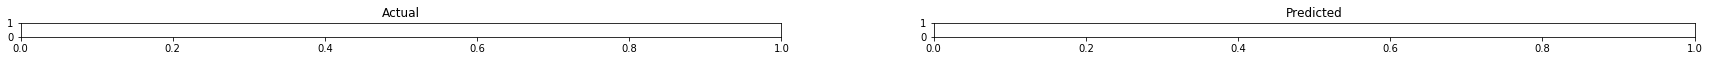

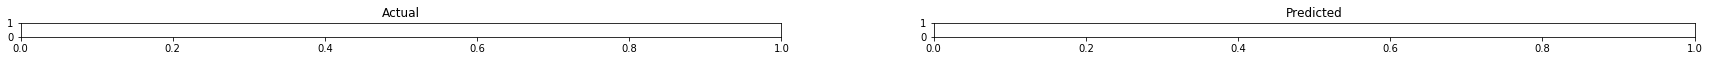

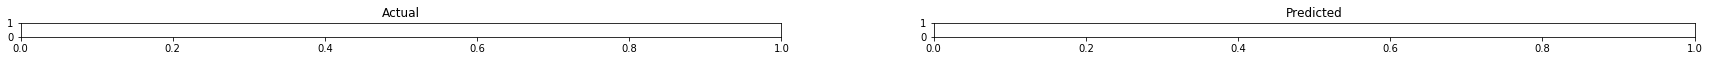

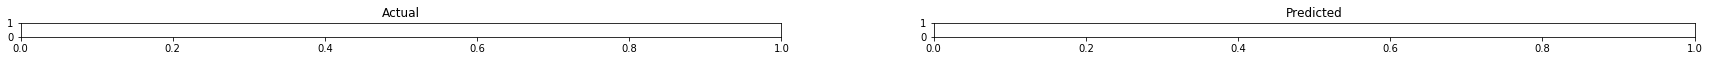

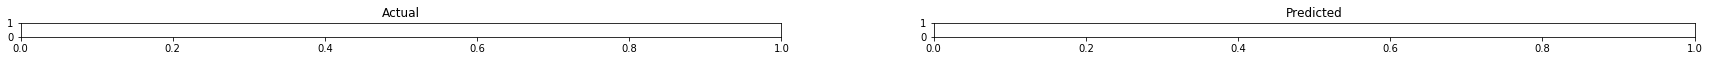

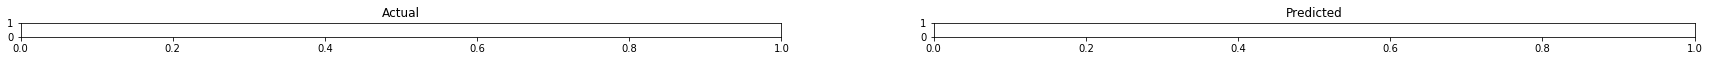

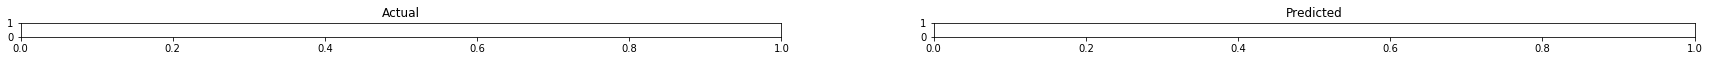

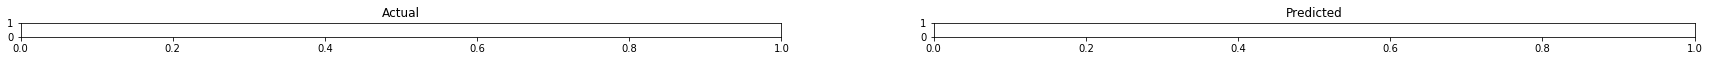

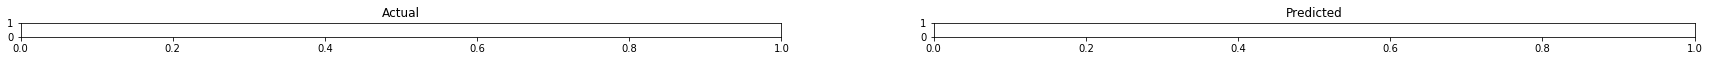

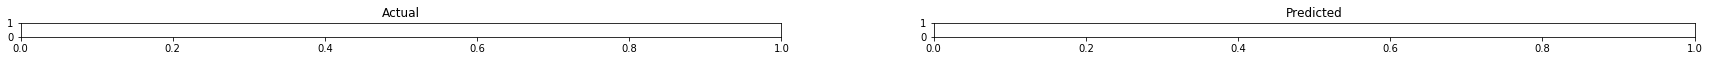

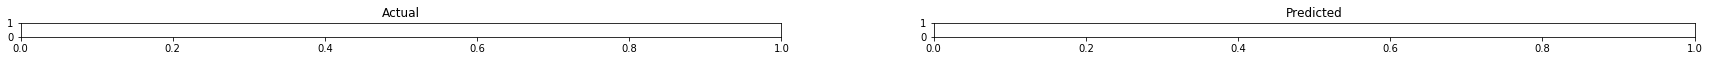

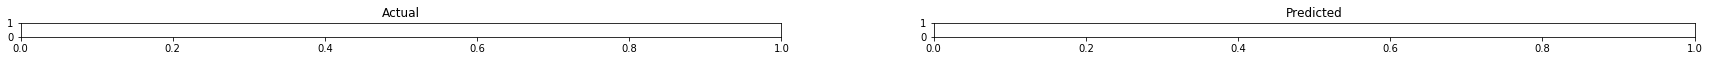

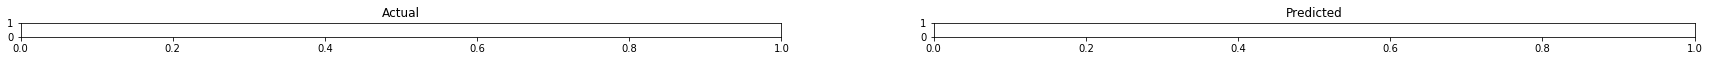

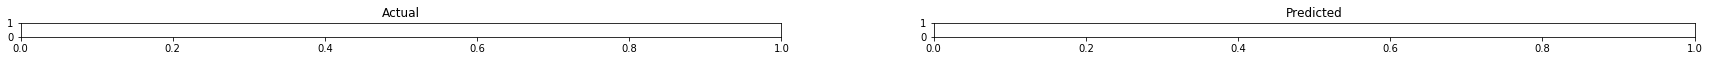

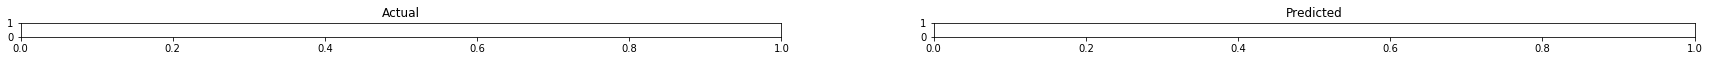

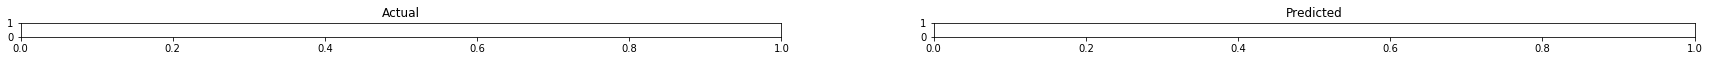

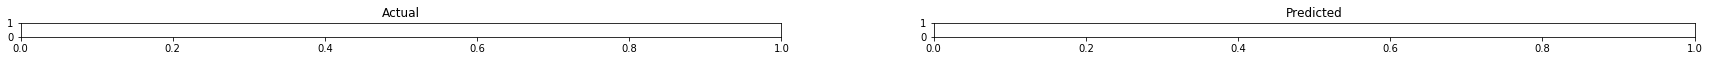

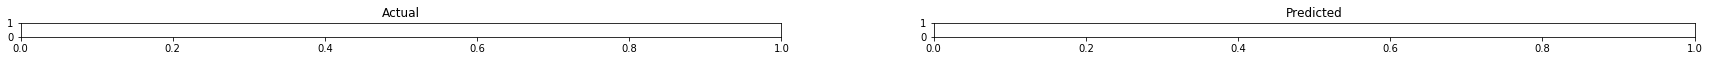

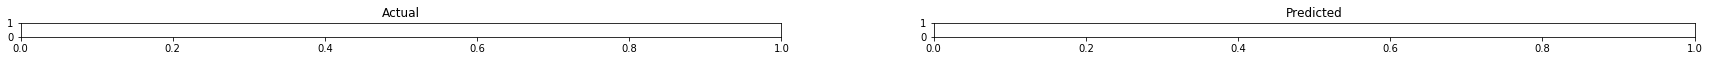

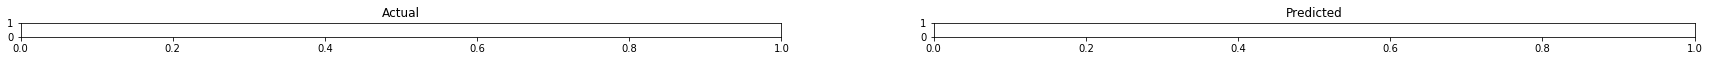

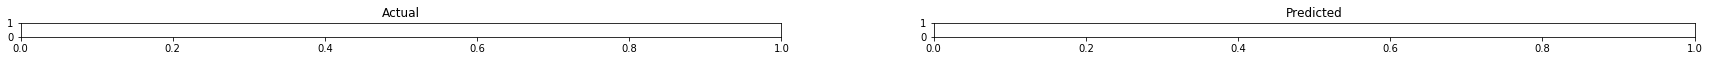

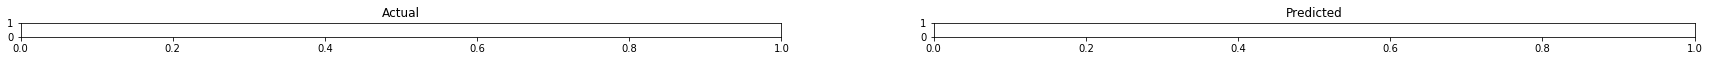

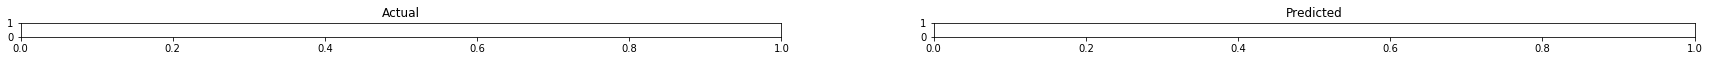

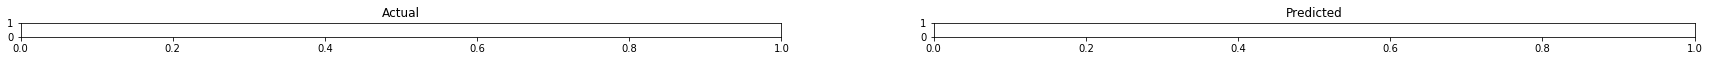

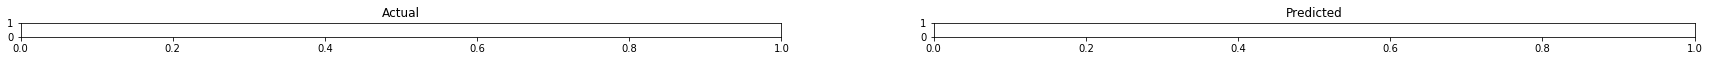

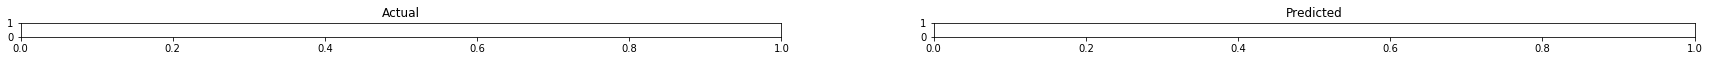

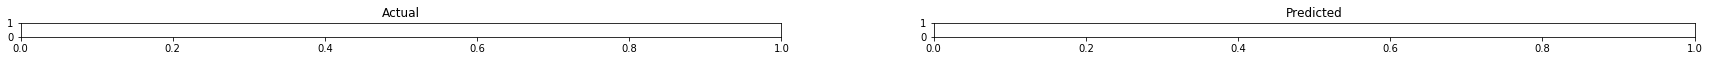

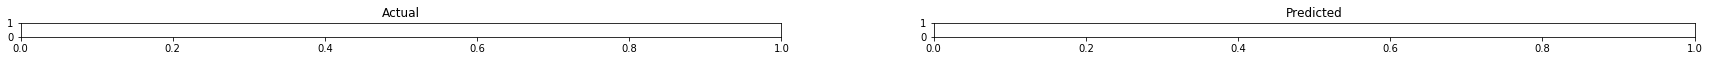

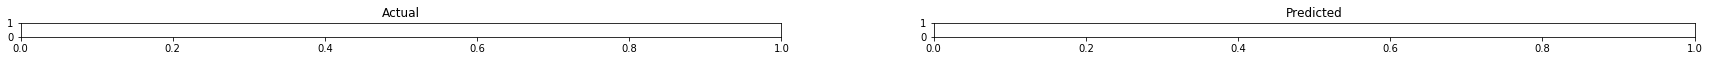

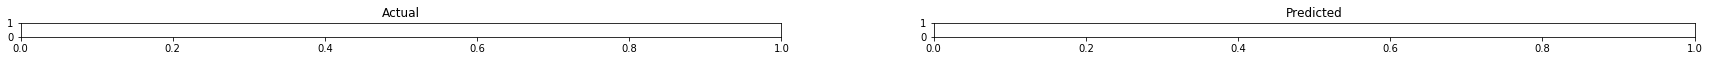

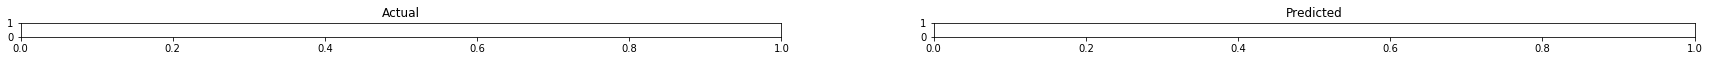

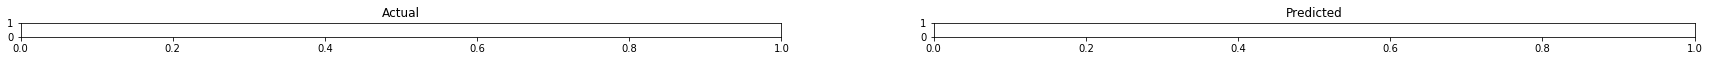

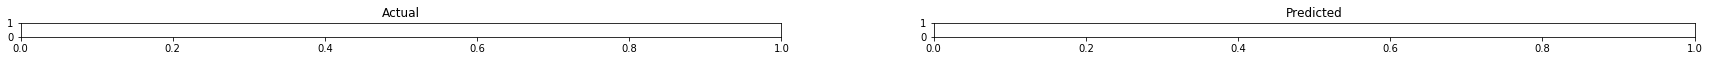

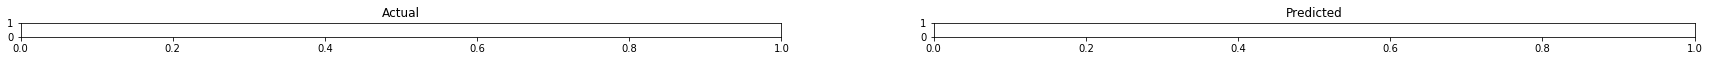

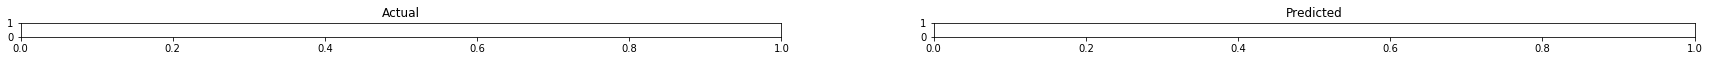

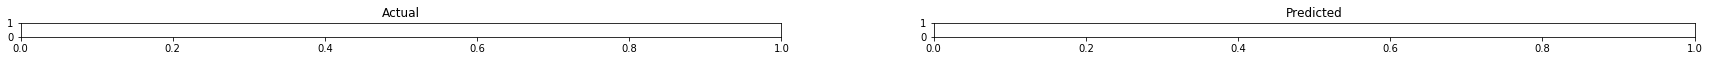

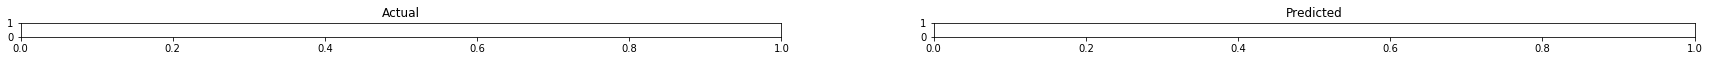

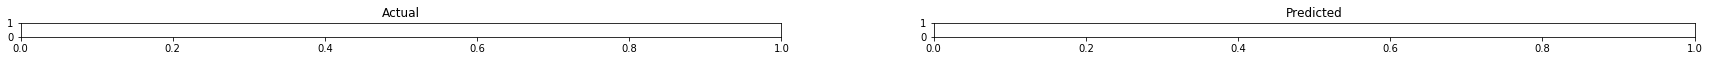

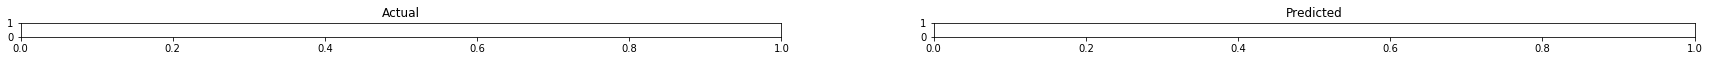

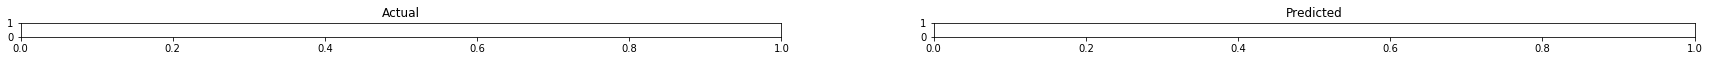

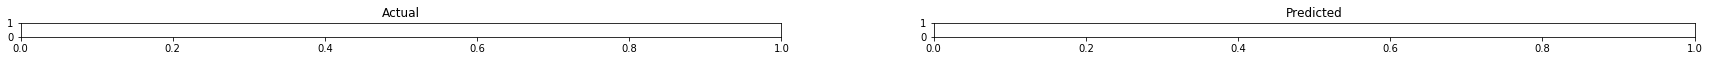

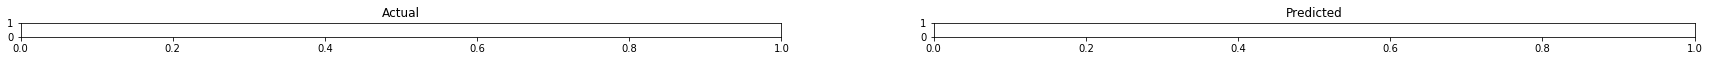

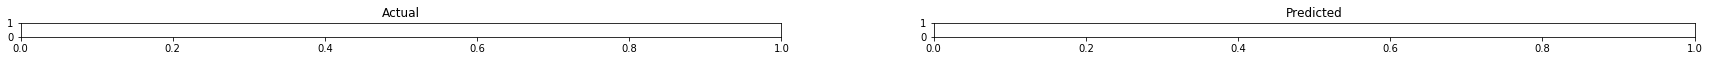

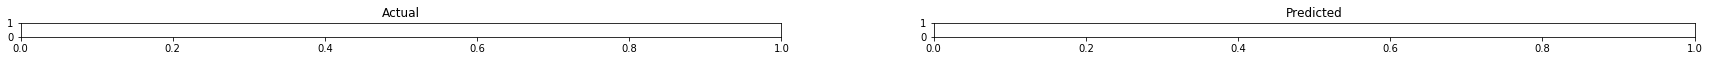

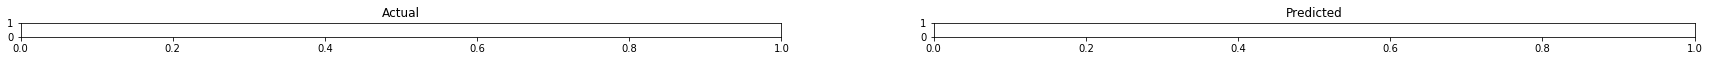

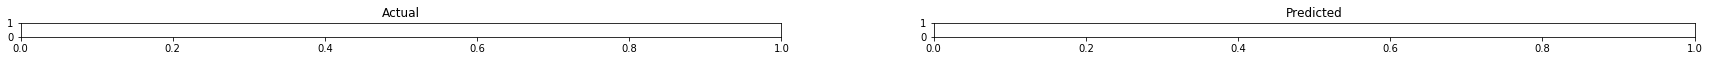

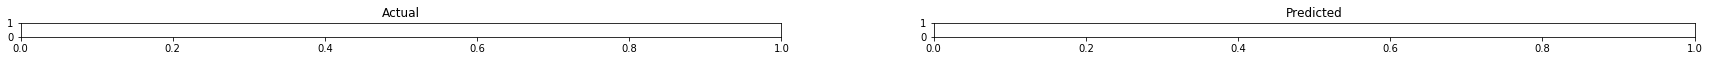

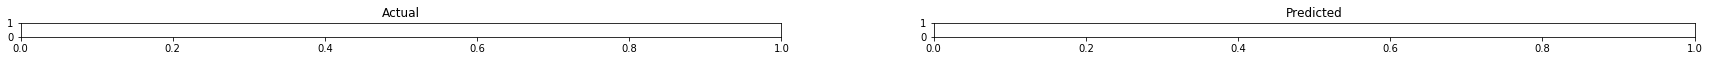

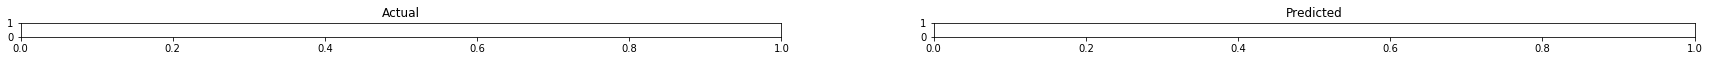

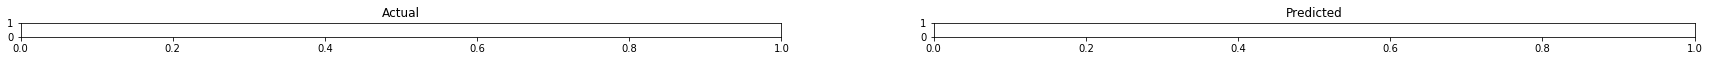

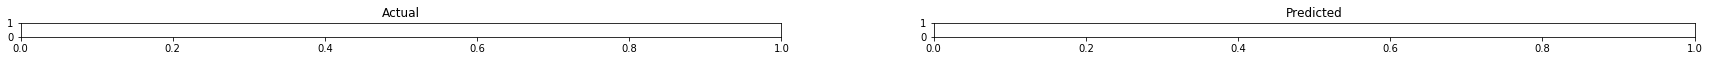

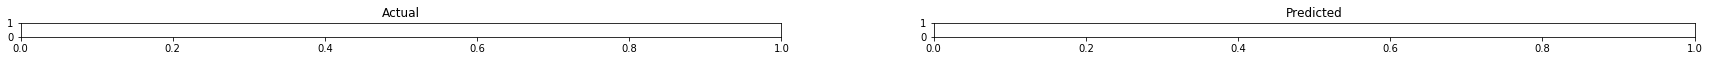

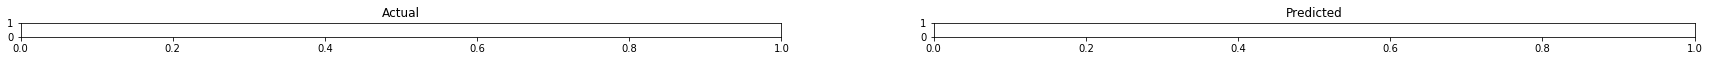

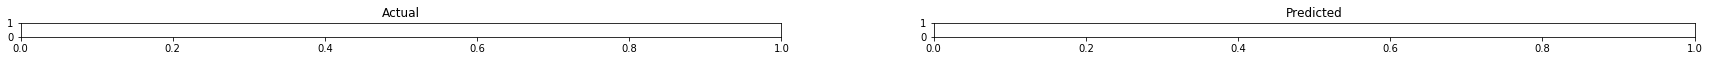

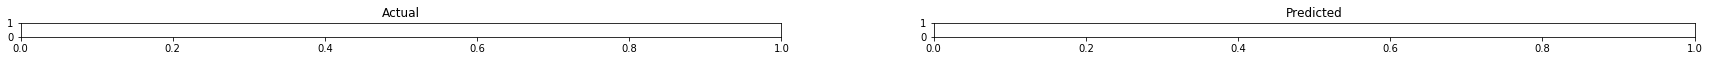

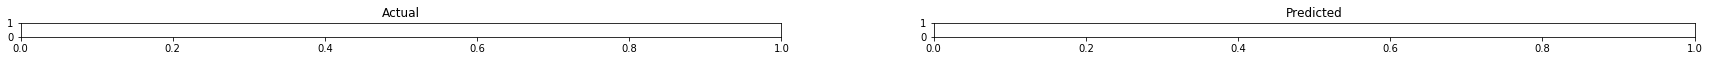

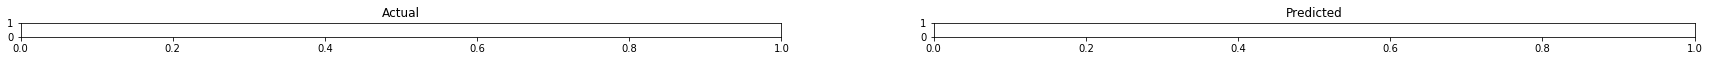

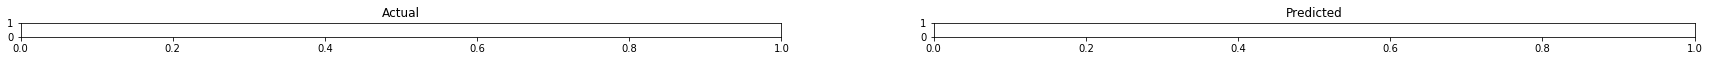

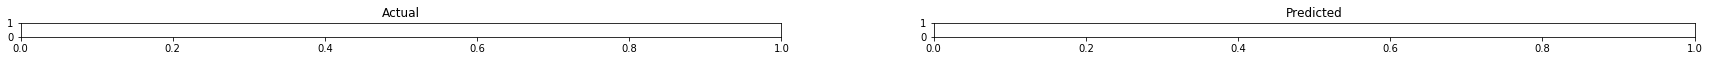

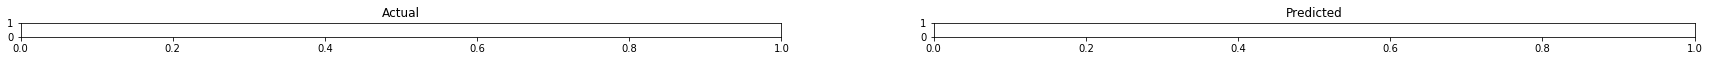

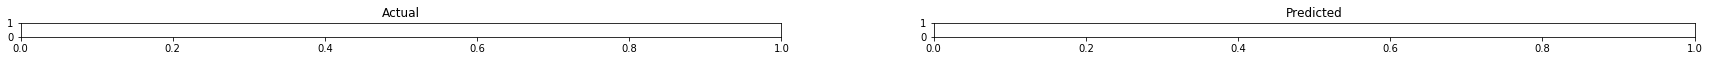

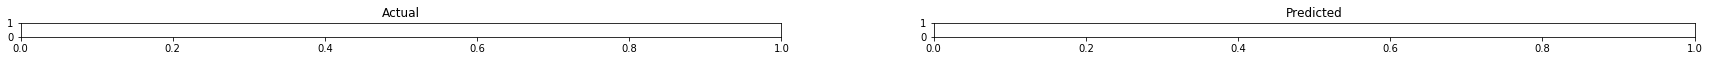

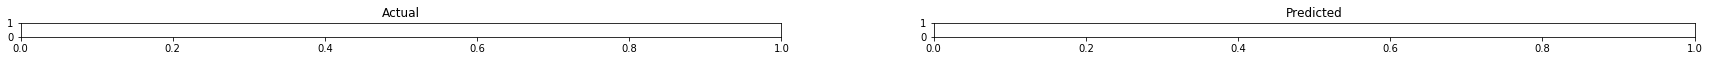

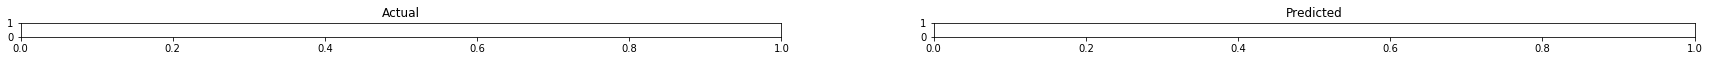

In [0]:
# truth_vs_pred(train_set, model, cfg)
truth_vs_pred(test_set, model, cfg)

In [0]:
# inference on video
import imutils
import cv2
import time

inp_vid = f'{drive_path}/MRCNN/test_video.mp4'
out_vid = f'{drive_path}/MRCNN/test_video_pred.mp4'

vs = cv2.VideoCapture(inp_vid)
writer = None

try:
	prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() else cv2.CAP_PROP_FRAME_COUNT
	total = int(vs.get(prop))
	print("[INFO] {} total frames in video".format(total))
except:
	print("[INFO] could not determine # of frames in video")
	print("[INFO] no approx. completion time can be provided")
	total = -1

while True:
  (grabbed, frame) = vs.read()
 
  if not grabbed:
    break


  blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (1024,1024), swapRB=True, crop=False)
  # scaled_image = mold_image(frame, cfg)
  # sample = expand_dims(scaled_image, 0)
  start = time.time()
  yhat = model.detect(blob, verbose=0)[0]
  end = time.time()

  for box in yhat['rois']:
    try:
      y1, x1, y2, x2 = box
    except:
      continue
    width, height = x2 - x1, y2 - y1

    cv2.rectangle(frame, (x1, y1), (x2, y2), (255,0,0), 2)
    # text = f'{conf:.3f}'
    # cv2.putText(sample, text, (x1, y2 + 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)

  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    writer = cv2.VideoWriter(out_vid, fourcc, 30,
      (frame.shape[1], frame.shape[0]), True)
  
    if total > 0:
      elap = (end - start)
      print("Single frame took {:.4f} seconds".format(elap))
      print("Estimated total time to finish: {:.4f}".format(
        elap * total))
  
  writer.write(frame)
 
# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()

[INFO] 2772 total frames in video


ValueError: ignored